## Business understanding

* Count the number of people in the image
* Can be used where the croud is present
* Use the same use case on Croud count in malls/shopping malls/fish farming/cattle farming

## Sources of information:

    * https://www.analyticsvidhya.com/blog/2019/08/3-techniques-extract-features-from-image-data-machine-learning-python/
    * https://www.analyticsvidhya.com/blog/2021/06/feature-detection-description-and-matching-of-images-using-opencv/
    * https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html
    * https://datahacker.rs/004-opencv-projects-how-to-extract-features-from-the-image-in-python/
    * https://medium.com/machine-learning-world/feature-extraction-and-similar-image-search-with-opencv-for-newbies-3c59796bf774
    * https://stackoverflow.com/

### Data Sources
    * https://www.kaggle.com/constantinwerner/human-detection-dataset/download
    * https://www.cis.upenn.edu/~jshi/ped_html/index.html#:~:text=Download%20zipped%20file-,here,-.%20Zipped%20file%20size
    * https://www.gettyimages.ie/

### Deployment Sources
        * https://devcenter.heroku.com/categories/python-support
        * https://realpython.com/flask-by-example-part-1-project-setup/
        * https://medium.com/featurepreneur/how-to-deploy-a-flask-app-on-heroku-part-1-14782c3068bc
        * https://medium.com/@rifaislamet1509/how-to-deploy-a-flask-app-to-heroku-d092ad2330d0

### Some work around

    * https://colab.research.google.com/drive/1AaV2YG0IOhPfrrfCugs0XbSUmyCg7bvR#scrollTo=TbiK2UOtCK3m&line=1&uniqifier=1
    * https://colab.research.google.com/drive/1JcqMRGGfUpuGXJSUl3bLvcjTGuzUdZvs?usp=sharing


Import the required libraries

In [1]:
import cv2
import os
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from skimage.feature import hog
import warnings
warnings.filterwarnings("ignore")

Obtaing data and create dataframe
In order for this image to be processed, the process of reading the image is performed first.

Download the data set from the link here - https://drive.google.com/drive/folders/1Lg8thKb_bRMN8G1yL4hkfh26--azdDMR?usp=sharing

In [2]:
ImagePath = 'Data/DataSet.csv'
ImageNames = pd.read_csv(ImagePath, header=0, index_col=False)
ImageNames['file'] = ImageNames['file'].apply(lambda x: 'Data/Train/'+x )

In [3]:
print(ImageNames.head())

                   file  people
0  Data/Train/1_288.png       0
1  Data/Train/1_311.png       0
2  Data/Train/1_328.png       0
3  Data/Train/1_363.png       0
4  Data/Train/1_429.png       0


Total of classes

In [4]:
ImageNames['people'].unique()

array([0, 1, 2, 3, 4, 5, 6])

One of the most popular libraries used for image processing is the OpenCV library. 
* First of all, libraries are imported. An important issue to note is that there are some functions in OpenCV that do not work stably in each version. 
* One of these functions is the imshow function. This function allows us to see changes in the image as a result of our actions. In this study, the matplotlib library was used as an alternative solution. HOG, or Histogram of Oriented Gradients, is a feature descriptor that is often used to extract features from image data. 
* It is widely used in computer vision tasks for object detection. HOG is able to provide the edge direction as well.

(408, 612)


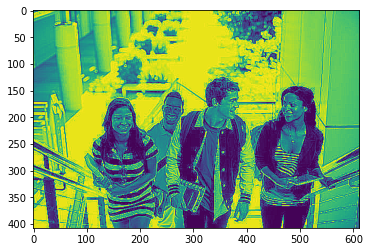

In [5]:
img = cv2.imread(ImageNames.iloc[303].tolist()[0], cv2.IMREAD_GRAYSCALE)
print(img.shape)
#img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#plt.imshow(img_gray)
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img2 = cv2.filter2D(img, -1, kernel)
plt.imshow(img2)

Here, We are going to use the hog function from skimage.features directly. The hog function would internally calculate it and return the feature matrix.Also, if you set the parameter ‘visualize = True’, it will return an image of the HOG.

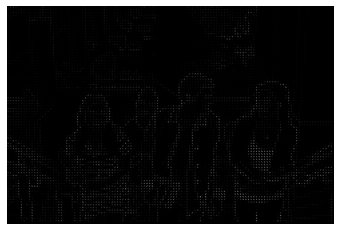

In [6]:

#creating hog features
fd, hog_image1 = hog(img, orientations=16, pixels_per_cell=(5, 5),
                	cells_per_block=(4, 4), visualize=True)#, multichannel=True)
plt.axis("off")
plt.imshow(hog_image1, cmap="gray")

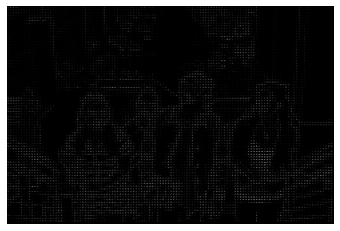

In [7]:
#creating hog2 features
fd, hog_image2 = hog(img2, orientations=9, pixels_per_cell=(5, 5),
                	cells_per_block=(10, 10), visualize=True)#, multichannel=True)
plt.axis("off")
plt.imshow(hog_image2, cmap="gray")


we load the data and use the try and exclude function to capture it in case of any error. 

In [8]:
def loadData():
    imag = []
    y=[]
    imagDir = ImageNames['file'].tolist()
    ab = ImageNames['people'].tolist()
    a = 0
    for i in imagDir:
        try:
            img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
            #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
            #img2 = cv2.filter2D(img, -1, kernel)
            img1 = cv2.resize(img, (256, 256))
            _, hog_image = hog(img1, orientations=16, pixels_per_cell=(5, 5),
                    cells_per_block=(4, 4), visualize=True)#, multichannel=True)
            new = hog_image.flatten() #hog_image.flatten()
            mag = np.array(new, dtype='float32')
            imag.append(mag)
            y.append(ab[a])
            a +=1 
        except Exception as E:
            print(E,i)
    #print(imag)
    return imag,y
        

Load Data to X and Y

In [9]:
X,y = loadData()
print('Length of X:', len(X), 'y: ', len(y))
#y = ImageNames['people'].tolist()

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Length of X: 417 y:  417


In [10]:
from collections import Counter
Counter(y)

Counter({0: 37, 1: 80, 2: 97, 3: 69, 4: 51, 5: 59, 6: 24})

Balancing the data, from the metric of precision and Recall

In [11]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

sample = RandomOverSampler(sampling_strategy='minority')
#sample = RandomUnderSampler(replacement=True)
 
# fit and apply the transform
X_over, y_over = SMOTE().fit_resample(X, y)

print(Counter(y_over))

Counter({0: 97, 1: 97, 2: 97, 3: 97, 4: 97, 5: 97, 6: 97})


we import machine learning algorithms that we will use.

In [12]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier # decision tee algorithm for classification
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR,SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve
from xgboost import XGBClassifier
import pickle

Define Stacking models

In [13]:
def get_stacking():
	# define the base models: level0 models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('cart', RandomForestClassifier(n_estimators=80, criterion='entropy')))
	level0.append(('svm', SVC(kernel='rbf')))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model: level 1
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=2)
	return model

In [14]:
rf = RandomForestClassifier(n_estimators=80, criterion='entropy')
lr = LogisticRegression()

def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['bayes'] = GaussianNB()
	models['svm_Linear'] = SVC(kernel='linear')
	models['svm_Polly'] = SVC(kernel='poly')
	models['svm_RBF'] = SVC(kernel='rbf')
	models['svm_Sigmoid'] = SVC(kernel='sigmoid')
	#models['Decision_Tree'] = DecisionTreeClassifier()
	models['dt_ent'] = DecisionTreeClassifier(criterion='entropy')
	models['dt_gini'] = DecisionTreeClassifier(criterion='gini')
	models['rf'] = RandomForestClassifier(n_estimators=80, criterion='entropy')
	models['adaboost'] = AdaBoostClassifier(base_estimator=lr, n_estimators=2)
	models['stacking'] = get_stacking()
	return models

In [15]:
import numpy as np

def evaluate_model_Multi(model, X, y):
  mc=20
  acc = [] ### Blank vector
  f = []
  prec = []
  rec = []
  for i in range(mc):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=i)# split dataset
    dt = model.fit(X_train,y_train) # fit the model
    YPred = dt.predict(X_test) # predict
    a = accuracy_score(y_test,YPred) # compute accuracy
    acc.append(a) # append accuracy
    f1 = f1_score(y_test, YPred, average='weighted')
    precision = precision_score(y_test, YPred, average='weighted')
    recall = recall_score(y_test, YPred, average='weighted')
    f.append(f1)
    prec.append(precision)
    rec.append(recall)
    return np.mean(acc), dt, np.mean(recall), np.mean(prec),np.mean(f)

In [16]:
def evaluate_model_cross(model, X, y):
	cv = 8
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv)
	return scores

We import the mean and standard deviation from the numpy library

In [17]:
from numpy import mean, std
import warnings
warnings.filterwarnings("ignore")
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores, mod, prec, recall,fscore = evaluate_model_Multi(model,X_over,y_over)#, X, y)
	results.append(scores)
	names.append(name)
	filename = 'Models/'+name+'.pkl'
	pickle.dump(mod, open(filename, 'wb'))
	print(name,'-- accuracy:', mean(scores), '-- Deviation',std(scores),'-- Precision ', mean(prec),'-- Recall', mean(recall),'-- Fscore:', mean(fscore))

lr -- accuracy: 0.7009803921568627 -- Deviation 0.0 -- Precision  0.7009803921568627 -- Recall 0.7210693830869715 -- Fscore: 0.7003764452442427
bayes -- accuracy: 0.4803921568627451 -- Deviation 0.0 -- Precision  0.4803921568627451 -- Recall 0.4918148943445949 -- Fscore: 0.47532636592140826
svm_Linear -- accuracy: 0.7352941176470589 -- Deviation 0.0 -- Precision  0.7352941176470589 -- Recall 0.7632142958869302 -- Fscore: 0.7340443854790425
svm_Polly -- accuracy: 0.4852941176470588 -- Deviation 0.0 -- Precision  0.4852941176470588 -- Recall 0.6199194700446264 -- Fscore: 0.49605743871350905
svm_RBF -- accuracy: 0.6127450980392157 -- Deviation 0.0 -- Precision  0.6127450980392157 -- Recall 0.6509071674512851 -- Fscore: 0.6224751190660789
svm_Sigmoid -- accuracy: 0.4950980392156863 -- Deviation 0.0 -- Precision  0.4950980392156863 -- Recall 0.5479498141358009 -- Fscore: 0.5007198977372112
dt_ent -- accuracy: 0.4411764705882353 -- Deviation 0.0 -- Precision  0.4411764705882353 -- Recall 0.4

provide results of models using cross validation

In [18]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model_cross(model, X_over, y_over)
	results.append(scores)
	names.append(name)
	filename = 'Models/'+name+'_cv.pkl'
	pickle.dump(model, open(filename, 'wb'))
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.723 (0.116)
>bayes 0.508 (0.105)
>svm_Linear 0.741 (0.102)
>svm_Polly 0.479 (0.049)
>svm_RBF 0.715 (0.139)
>svm_Sigmoid 0.548 (0.132)
>dt_ent 0.502 (0.106)
>dt_gini 0.476 (0.112)
>rf 0.691 (0.146)
>adaboost 0.718 (0.119)
>stacking 0.718 (0.106)


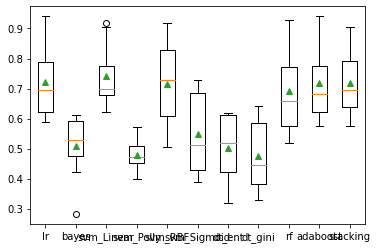

In [19]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

Checking Different Test size for Ada boost Classifier, which is one of the ensemble methods

In [20]:
import numpy as np

tsize = [0.2,0.3,0.4,0.5,0.6]
tsize_acc = {}
for i in tsize:
    acc = []
    for j in range(20):
        X_train,X_test,y_train,y_test = train_test_split(X_over,y_over,test_size=i, random_state = j)
        ab= LogisticRegression() #AdaBoostClassifier(base_estimator=rf, n_estimators=2)
        ab.fit(X_train, y_train)
        dt_pred = ab.predict(X_test)
        accuracy = accuracy_score(y_test,dt_pred)
        acc.append(accuracy)
    tsize_acc.update({i:np.mean(acc)})
print(tsize_acc)

{0.2: 0.7176470588235294, 0.3: 0.7078431372549019, 0.4: 0.6840073529411764, 0.5: 0.6533823529411764, 0.6: 0.6117647058823529}


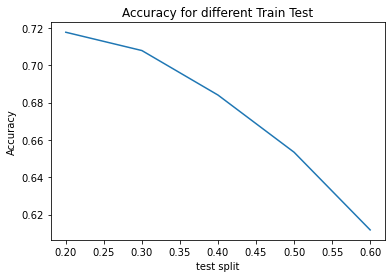

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(*zip(*sorted(tsize_acc.items())))
plt.ylabel('Accuracy'); plt.xlabel('test split'); plt.title('Accuracy for different Train Test');
plt.show()

Checking Number of estimators for Random Forest Classifier 

In [22]:
num_est = np.arange(10,100,10)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    rf = RandomForestClassifier(n_estimators = n_est, criterion='entropy')
    scores = cross_val_score(rf, X_over, y_over, cv=8, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

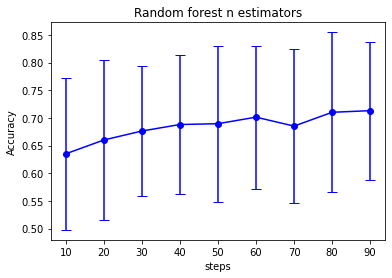

In [23]:
plt.figure()
plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std,c='blue', fmt='-o', capsize=5)
plt.ylabel('Accuracy'); plt.xlabel('steps'); plt.title('Random forest n estimators');
plt.show()

Checking different K-Fold cross validation for Random Forest Classifier 

In [24]:
num_est = np.arange(2,20,4)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    rf = RandomForestClassifier(n_estimators = 70, criterion='entropy')
    scores = cross_val_score(rf, X_over, y_over, cv=n_est, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

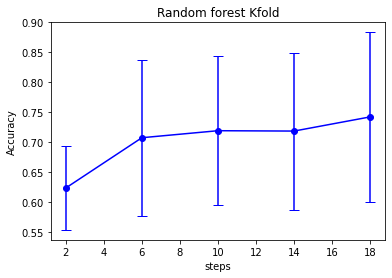

In [25]:
plt.figure()
plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std,c='blue', fmt='-o', capsize=5)
plt.ylabel('Accuracy'); plt.xlabel('steps'); plt.title('Random forest Kfold');
plt.show()

Checking Number of estimaters for Ada Boost Classifier 

In [26]:
from sklearn.ensemble import AdaBoostClassifier

rf = RandomForestClassifier(n_estimators=80, criterion='entropy')

num_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

In [27]:
num_est = np.arange(2,10,2)
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=rf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, X_over, y_over, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

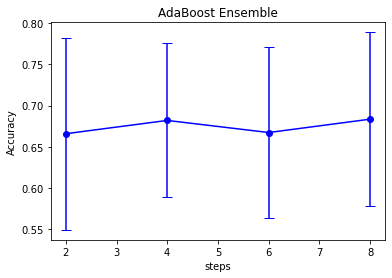

In [28]:
plt.figure()
plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std,c='blue', fmt='-o', capsize=5)
plt.ylabel('Accuracy'); plt.xlabel('steps'); plt.title('AdaBoost Ensemble');
plt.show()

Testing With new data set

In [19]:
def testData(ImageNames):
    imag = []
    y=[]
    imagDir = ImageNames['file'].tolist()
    ab = ImageNames['people'].tolist()
    a = 0
    for i in imagDir:
        img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
        #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        #img2 = cv2.filter2D(img, -1, kernel)
        img1 = cv2.resize(img, (256, 256))
        _, hog_image = hog(img1, orientations=16, pixels_per_cell=(5, 5),
                    cells_per_block=(4, 4), visualize=True)#, multichannel=True)
        new = hog_image.flatten() #hog_image.flatten()
        mag = np.array(new, dtype='float32')
        imag.append(mag)
        y.append(ab[a])
        a +=1 
    return imag,y

def Feat(FileName):
    img = cv2.imread(FileName, cv2.IMREAD_GRAYSCALE)
    #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    #img2 = cv2.filter2D(img, -1, kernel)
    img1 = cv2.resize(img, (256, 256))
    _, hog_image = hog(img1, orientations=16, pixels_per_cell=(5, 5),
                    cells_per_block=(4, 4), visualize=True)#, multichannel=True)
    new = hog_image.flatten() #hog_image.flatten()
    mag = np.array(new, dtype='float32')
    return [mag], hog_image,img1

load the model from disk

libpng warning: iCCP: known incorrect sRGB profile


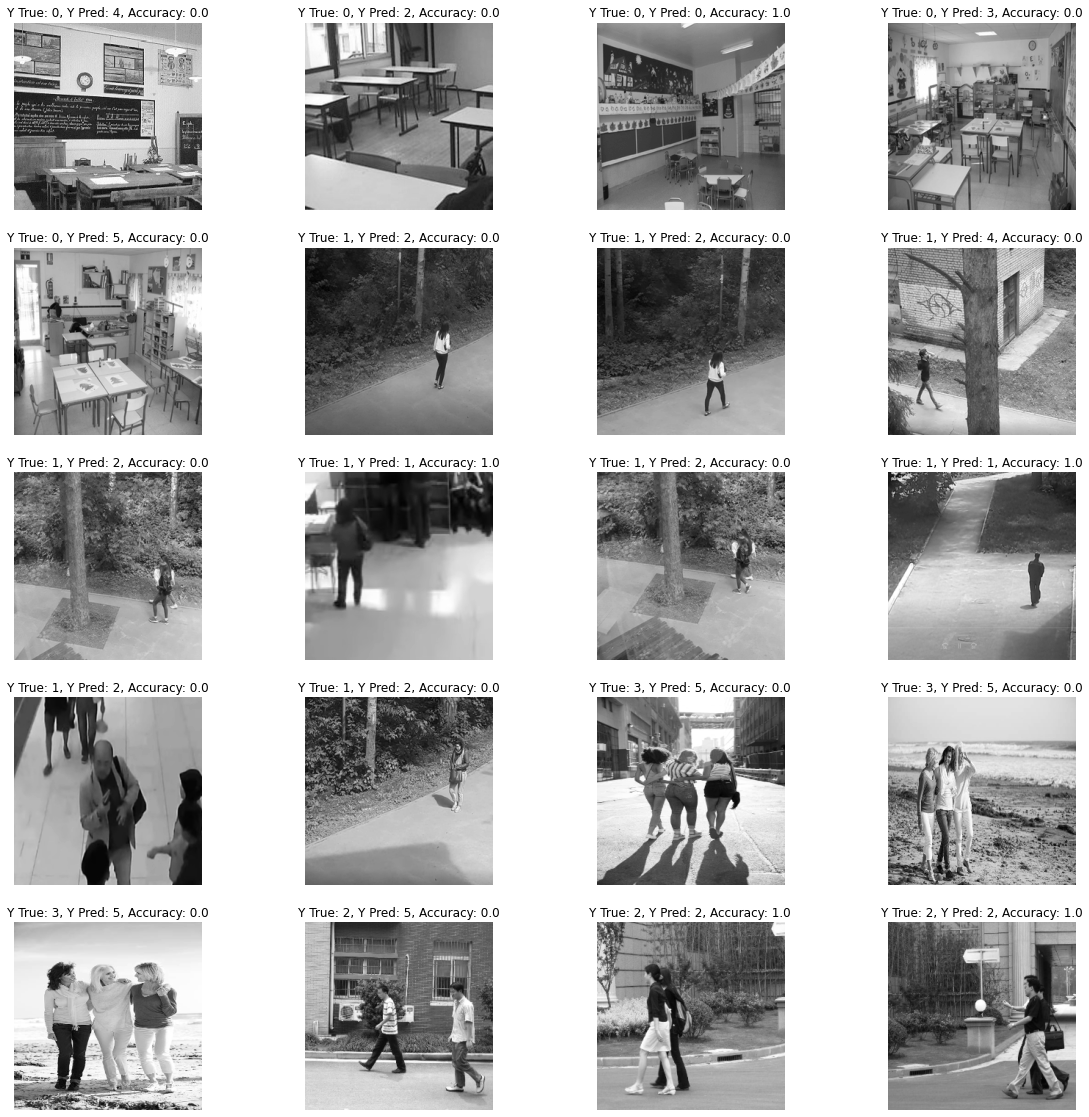

In [31]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import cv2
from skimage.feature import hog
import pickle
from sklearn.metrics import accuracy_score

ImagePath = 'Data/test.csv'
TestImage = pd.read_csv(ImagePath, header=0, index_col=False)
model_name = '/Users/admin/DBS_Assisgnments/MachineLearning/Models/svm_Linear.pkl'

TestImage['file'] = TestImage['file'].apply(lambda x: '/Users/admin/DBS_Assisgnments/MachineLearning/Data/Test/'+x )

# load the model from disk
#X_test, y_test = testData(TestImage)
plt.figure(figsize=(20,20))
b = 10
for i in range(20):
    #creating hog features
    a = []
    #print(TestImage.iloc[i].tolist()[0])
    X_test, hog_img, img = Feat(TestImage.iloc[i].tolist()[0])
    y_test = [TestImage.iloc[i].tolist()[1]]

    loaded_model = pickle.load(open(model_name, 'rb'))
    #result = loaded_model.score(X_test, y_pred)
    y_pred = loaded_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred) # compute accuracy
    plt.subplot(5,4,i+1)
    plt.imshow(img, cmap="gray")
    plt.title('Y True: '+str(y_test[0])+', '+'Y Pred: '+str(y_pred[0]) +', '+'Accuracy: '+str(acc))
    plt.axis('off')
       



Bagging Approch